In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 128


In [3]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [4]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [16]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3985, Train Acc=0.1060, Val Acc=0.1499, Test Acc=0.1693
Fold 1/5, Epoch 2: Train Loss=3.2131, Train Acc=0.1608, Val Acc=0.1508, Test Acc=0.1705
Fold 1/5, Epoch 3: Train Loss=3.0750, Train Acc=0.1788, Val Acc=0.1957, Test Acc=0.2345
Fold 1/5, Epoch 4: Train Loss=2.9506, Train Acc=0.2065, Val Acc=0.2191, Test Acc=0.2666
Fold 1/5, Epoch 5: Train Loss=2.8217, Train Acc=0.2568, Val Acc=0.2480, Test Acc=0.3085
Fold 1/5, Epoch 6: Train Loss=2.6964, Train Acc=0.2992, Val Acc=0.2663, Test Acc=0.3296
Fold 1/5, Epoch 7: Train Loss=2.5781, Train Acc=0.3218, Val Acc=0.2945, Test Acc=0.3680
Fold 1/5, Epoch 8: Train Loss=2.4570, Train Acc=0.3549, Val Acc=0.3002, Test Acc=0.3822
Fold 1/5, Epoch 9: Train Loss=2.3506, Train Acc=0.3811, Val Acc=0.3175, Test Acc=0.4144
Fold 1/5, Epoch 10: Train Loss=2.2443, Train Acc=0.4195, Val Acc=0.3316, Test Acc=0.4468
Fold 1/5, Epoch 11: Train Loss=2.1576, Train Acc=0.4521, Val Acc=0.3501, Test Acc=0.4830
Fold 1/

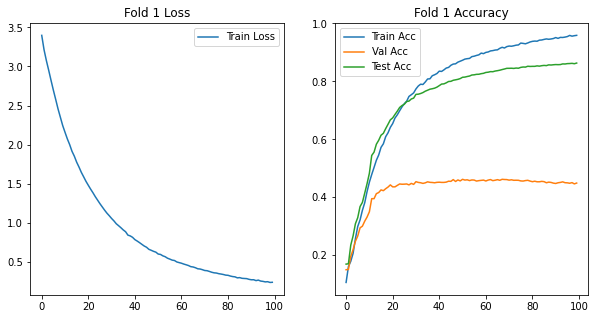

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4275, Train Acc=0.1068, Val Acc=0.1523, Test Acc=0.1696
Fold 2/5, Epoch 2: Train Loss=3.2265, Train Acc=0.1633, Val Acc=0.1649, Test Acc=0.1902
Fold 2/5, Epoch 3: Train Loss=3.0806, Train Acc=0.1755, Val Acc=0.1693, Test Acc=0.2033
Fold 2/5, Epoch 4: Train Loss=2.9511, Train Acc=0.1977, Val Acc=0.1805, Test Acc=0.2105
Fold 2/5, Epoch 5: Train Loss=2.8311, Train Acc=0.2362, Val Acc=0.2465, Test Acc=0.2933
Fold 2/5, Epoch 6: Train Loss=2.7130, Train Acc=0.2853, Val Acc=0.2733, Test Acc=0.3277
Fold 2/5, Epoch 7: Train Loss=2.5884, Train Acc=0.3164, Val Acc=0.3052, Test Acc=0.3667
Fold 2/5, Epoch 8: Train Loss=2.4744, Train Acc=0.3530, Val Acc=0.3259, Test Acc=0.3963
Fold 2/5, Epoch 9: Train Loss=2.3630, Train Acc=0.3907, Val Acc=0.3369, Test Acc=0.4323
Fold 2/5, Epoch 10: Train Loss=2.2614, Train Acc=0.4245, Val Acc=0.3807, Test Acc=0.4951
Fold 2/5, Epoch 11: Train Loss=2.1657, Train Acc=0.4579, Val Acc=0.3923, Test Acc=0.5221
Fold 2/

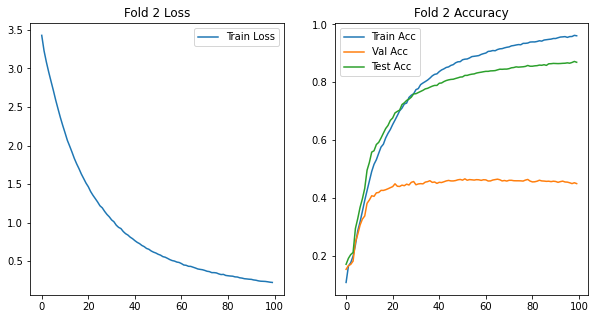

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4109, Train Acc=0.1027, Val Acc=0.1598, Test Acc=0.1598
Fold 3/5, Epoch 2: Train Loss=3.2241, Train Acc=0.1528, Val Acc=0.1962, Test Acc=0.2060
Fold 3/5, Epoch 3: Train Loss=3.0772, Train Acc=0.1791, Val Acc=0.2037, Test Acc=0.2218
Fold 3/5, Epoch 4: Train Loss=2.9515, Train Acc=0.2023, Val Acc=0.2200, Test Acc=0.2379
Fold 3/5, Epoch 5: Train Loss=2.8349, Train Acc=0.2433, Val Acc=0.2522, Test Acc=0.2855
Fold 3/5, Epoch 6: Train Loss=2.7185, Train Acc=0.2865, Val Acc=0.2981, Test Acc=0.3375
Fold 3/5, Epoch 7: Train Loss=2.6067, Train Acc=0.3163, Val Acc=0.3176, Test Acc=0.3557
Fold 3/5, Epoch 8: Train Loss=2.4840, Train Acc=0.3491, Val Acc=0.3339, Test Acc=0.3784
Fold 3/5, Epoch 9: Train Loss=2.3762, Train Acc=0.3685, Val Acc=0.3432, Test Acc=0.4072
Fold 3/5, Epoch 10: Train Loss=2.2804, Train Acc=0.4051, Val Acc=0.3568, Test Acc=0.4366
Fold 3/5, Epoch 11: Train Loss=2.1882, Train Acc=0.4339, Val Acc=0.3936, Test Acc=0.4944
Fold 3/

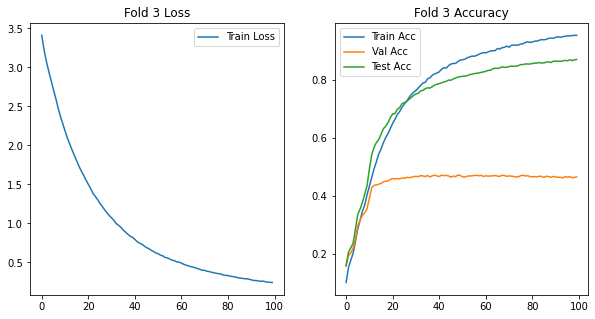

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4003, Train Acc=0.1124, Val Acc=0.1375, Test Acc=0.1543
Fold 4/5, Epoch 2: Train Loss=3.2240, Train Acc=0.1505, Val Acc=0.1573, Test Acc=0.1900
Fold 4/5, Epoch 3: Train Loss=3.0818, Train Acc=0.1785, Val Acc=0.1843, Test Acc=0.2315
Fold 4/5, Epoch 4: Train Loss=2.9588, Train Acc=0.2031, Val Acc=0.1870, Test Acc=0.2430
Fold 4/5, Epoch 5: Train Loss=2.8433, Train Acc=0.2393, Val Acc=0.2389, Test Acc=0.3011
Fold 4/5, Epoch 6: Train Loss=2.7234, Train Acc=0.2802, Val Acc=0.2703, Test Acc=0.3316
Fold 4/5, Epoch 7: Train Loss=2.6031, Train Acc=0.3128, Val Acc=0.2828, Test Acc=0.3549
Fold 4/5, Epoch 8: Train Loss=2.4821, Train Acc=0.3406, Val Acc=0.3023, Test Acc=0.3855
Fold 4/5, Epoch 9: Train Loss=2.3752, Train Acc=0.3762, Val Acc=0.3053, Test Acc=0.4046
Fold 4/5, Epoch 10: Train Loss=2.2706, Train Acc=0.4115, Val Acc=0.3377, Test Acc=0.4545
Fold 4/5, Epoch 11: Train Loss=2.1756, Train Acc=0.4491, Val Acc=0.3719, Test Acc=0.5114
Fold 4/

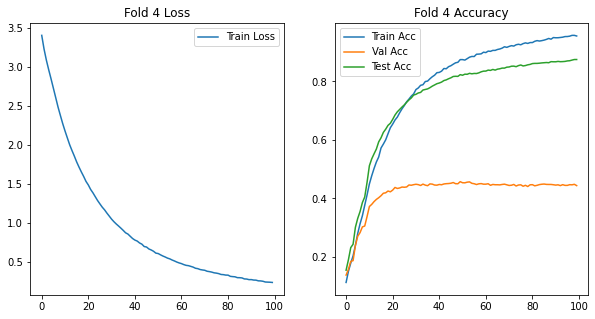

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3986, Train Acc=0.1220, Val Acc=0.1518, Test Acc=0.1634
Fold 5/5, Epoch 2: Train Loss=3.2029, Train Acc=0.1542, Val Acc=0.1774, Test Acc=0.2118
Fold 5/5, Epoch 3: Train Loss=3.0698, Train Acc=0.1755, Val Acc=0.1989, Test Acc=0.2309
Fold 5/5, Epoch 4: Train Loss=2.9536, Train Acc=0.2019, Val Acc=0.1974, Test Acc=0.2381
Fold 5/5, Epoch 5: Train Loss=2.8224, Train Acc=0.2414, Val Acc=0.2518, Test Acc=0.3050
Fold 5/5, Epoch 6: Train Loss=2.7086, Train Acc=0.2869, Val Acc=0.2827, Test Acc=0.3388
Fold 5/5, Epoch 7: Train Loss=2.5821, Train Acc=0.3172, Val Acc=0.3113, Test Acc=0.3683
Fold 5/5, Epoch 8: Train Loss=2.4599, Train Acc=0.3508, Val Acc=0.3111, Test Acc=0.3783
Fold 5/5, Epoch 9: Train Loss=2.3540, Train Acc=0.3804, Val Acc=0.3311, Test Acc=0.4186
Fold 5/5, Epoch 10: Train Loss=2.2602, Train Acc=0.4159, Val Acc=0.3604, Test Acc=0.4640
Fold 5/5, Epoch 11: Train Loss=2.1636, Train Acc=0.4523, Val Acc=0.3845, Test Acc=0.5134
Fold 5/

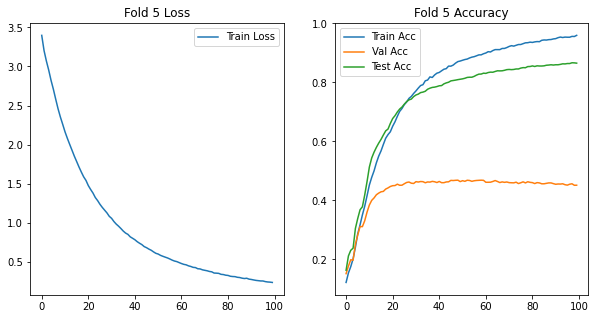

In [17]:
num_epochs = 100
k = 5

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset.dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [18]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [19]:
Train_acc

[0.9587104708721976,
 0.960525844788087,
 0.9548265934380625,
 0.9549953465063001,
 0.9592461340206185]

In [20]:
Val_acc

[0.4490411931818182,
 0.4489080255681818,
 0.4662198153409091,
 0.44349254261363635,
 0.4514825994318182]

In [21]:
Test_acc

[0.8631019776570049,
 0.8688198218599034,
 0.8718438632246377,
 0.8745848429951691,
 0.8650551026570049]

In [22]:
np.mean(Train_acc)

0.9576608779250533

In [23]:
np.mean(Val_acc)

0.45182883522727274

In [24]:
np.mean(Test_acc)

0.868681121678744

In [25]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [26]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.8631
Test Accuracy: 0.8688
Test Accuracy: 0.8718
Test Accuracy: 0.8746
Test Accuracy: 0.8651


In [27]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 1,  4, 23, 13, 31, 27,  7,  1, 18, 21,  4, 24, 16, 21,  4, 22, 23, 27,
        26, 24, 11,  2,  7,  1, 18, 15, 25,  1,  8, 15,  4, 15,  6, 32, 31,  0,
        27, 15, 27,  1, 18, 18, 13,  0,  1, 29, 29, 27, 27, 16, 14, 29, 13, 14,
        29, 18,  1,  2, 18, 23,  2,  4, 25, 13, 25,  4,  3,  6, 16, 27,  0, 27,
        25, 15, 27, 15,  8, 18, 24,  1, 18,  4,  1, 31, 26, 20,  4, 23,  1, 22,
        27, 13, 27, 29, 25, 15, 25, 29, 16, 24, 27,  7, 32, 18, 15, 11, 29,  1,
         0, 27, 22, 18, 24, 13,  7, 21,  8,  6,  8, 11,  1, 27,  8, 24, 13, 28,
        27,  6], device='cuda:0')
tensor([ 1, 14,  7, 13, 31, 27,  7,  1, 18, 24,  4, 24, 29, 21,  4, 22, 18, 32,
        26, 24, 11,  2,  7,  1, 18, 15, 25, 25,  8, 15,  4, 15,  6, 32, 31,  0,
        27, 15, 27,  1,  1, 18, 13,  0,  1, 29, 29, 27, 27, 16, 14, 25, 13, 14,
        29, 18,  1, 16, 18, 25,  2,  4, 25, 13, 25,  4,  3,  6, 16, 27, 11, 12,
        25, 15, 12,  7, 25, 18, 24,  1, 18,  4,  1, 31, 26,  1,  4, 23,  1, 22,
      